# Regime Prediction with HMM + XGBoost + Feature Selection
This notebook uncovers market regimes using a Gaussian Hidden Markov Model (HMM), selects top features using model-based feature selection, and trains an XGBoost classifier to predict regimes.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from hmmlearn import hmm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

/Users/nikita/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import sys
import os

# Add the repo root to Python path so you can import from backend/
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(repo_root)

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from backend.data_fetcher import fetch_stock_data, DataFetcher
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
tickers = ["AAPL", "MSFT", "GOOG"]
start = "2020-01-01"
end = "2023-01-01"

# Fetch data 
metrics = fetch_stock_data(tickers, start, end)
prices = metrics['prices']
returns = prices.pct_change().dropna()
metrics['returns'] = returns
# print(metrics)

In [6]:
# Step 1: Your original feature engineering function
def create_features(returns_df):
    mean = returns_df.mean(axis=1)
    std = returns_df.std(axis=1)
    rolling_mean = returns_df.rolling(5).mean().mean(axis=1)
    rolling_std = returns_df.rolling(5).std().mean(axis=1)
    q10 = returns_df.quantile(0.1, axis=1)
    q90 = returns_df.quantile(0.9, axis=1)

    correlations = []
    for i in returns_df.columns:
        for j in returns_df.columns:
            if i < j:
                correlations.append(returns_df[i].rolling(10).corr(returns_df[j]))
    avg_corr = pd.concat(correlations, axis=1).mean(axis=1)

    features = pd.DataFrame({
        'mean': mean,
        'std': std,
        'roll_mean': rolling_mean,
        'roll_std': rolling_std,
        'q10': q10,
        'q90': q90,
        'avg_corr': avg_corr
    }).fillna(method='ffill').fillna(method='bfill')
    
    return features

# Step 2: Generate the engineered features
features = create_features(returns)

# Step 3: Create metadata dataframe from Yahoo Finance metrics
market_caps = metrics['market_caps']
volumes = metrics['volumes']
volatilities = metrics['volatilities']
returns = metrics['prices'].pct_change().dropna()

meta_df = pd.DataFrame({
    'market_cap': market_caps,
    'volume': volumes,
    'volatility': volatilities
})

# Make sure the order of tickers matches the columns in your returns
meta_df = meta_df.loc[returns.columns]
meta_df = meta_df.fillna(0)

# Step 4: Collapse ticker-level info into a single row (average across tickers)
avg_meta = {
    'avg_market_cap': meta_df['market_cap'].mean(),
    'avg_volume': meta_df['volume'].mean(),
    'avg_volatility': meta_df['volatility'].mean()
}

# Step 5: Repeat metadata across all time rows to match shape of features
meta_time_series = pd.DataFrame([avg_meta] * len(features), index=features.index)

# Step 6: Combine everything
full_features = pd.concat([features, meta_time_series], axis=1)

print("Combined feature shape:", full_features.shape)
print(full_features.head())

Combined feature shape: (755, 10)
                mean       std  roll_mean  roll_std       q10       q90  \
Date                                                                      
2020-01-03 -0.009027  0.003820   0.005224   0.01244 -0.011906 -0.005870   
2020-01-06  0.011737  0.011509   0.005224   0.01244  0.003661  0.021319   
2020-01-07 -0.004815  0.004248   0.005224   0.01244 -0.008235 -0.001440   
2020-01-08  0.013298  0.004693   0.005224   0.01244  0.009490  0.016055   
2020-01-09  0.014926  0.005516   0.005224   0.01244  0.011334  0.019491   

            avg_corr  avg_market_cap  avg_volume  avg_volatility  
Date                                                              
2020-01-03  0.667123    2.430514e+12  32926630.0        0.353537  
2020-01-06  0.667123    2.430514e+12  32926630.0        0.353537  
2020-01-07  0.667123    2.430514e+12  32926630.0        0.353537  
2020-01-08  0.667123    2.430514e+12  32926630.0        0.353537  
2020-01-09  0.667123    2.430514e+12  

/var/folders/54/4gpjnqfj49sgvzbjhxtjjz1w0000gn/T/ipykernel_18508/300501881.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = pd.DataFrame({


In [11]:
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
# Drop non-numeric columns (like 'date') before scaling
full_features = full_features.drop(columns=["date"], errors='ignore')

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(full_features)

# init HMM model
hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=42)
hmm_model.fit(normalized_features)
hmm_labels = hmm_model.predict(normalized_features)

# Store HMM regime labels in the DataFrame
full_features["regime"] = hmm_labels
full_features["date"] = full_features.index
#print(full_features[["regime"]].value_counts())

Model is not converging.  Current: 11111.257790409209 is not greater than 30338.183718063094. Delta is -19226.925927653887


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

# Prepare features and labels
X = full_features.drop(columns=["regime", "date"])
y = full_features["regime"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Train XGBoost model on all features
model_full = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)

# Print classification report for all features
print("Classification Report (All Features)")
print(classification_report(y_test, y_pred_full))

# Feature selection using XGBoost
selector = SelectFromModel(model_full, threshold="median", prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Train XGBoost model on selected features
model_selected = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
model_selected.fit(X_train_selected, y_train)
y_pred_selected = model_selected.predict(X_test_selected)

# Print classification report for selected features
print("Classification Report (Selected Features)")
print(classification_report(y_test, y_pred_selected))

# Compare feature counts
print(f"Original feature count: {X.shape[1]}")
print(f"Selected feature count: {X_train_selected.shape[1]}")

/Users/nikita/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:17:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (All Features)
              precision    recall  f1-score   support

           1       0.96      0.96      0.96       139
           2       0.50      0.50      0.50        12

    accuracy                           0.92       151
   macro avg       0.73      0.73      0.73       151
weighted avg       0.92      0.92      0.92       151



/Users/nikita/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:17:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (Selected Features)
              precision    recall  f1-score   support

           1       0.96      0.95      0.96       139
           2       0.50      0.58      0.54        12

    accuracy                           0.92       151
   macro avg       0.73      0.77      0.75       151
weighted avg       0.93      0.92      0.92       151

Original feature count: 10
Selected feature count: 5


We used a model-based feature selection approach with XGBoost, a gradient boosting tree algorithm. After fitting the classifier to the full feature set, each feature is assigned an importance score based on how often it was used in decision tree splits and how much it contributed to improving accuracy. Leverage SelectFromModel to retain the most informative features, based on their relative importance. This helps reduce dimensionality and improve model performance

In [23]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

def calculate_regime_stats(returns_df, predicted_regimes):
    regimes = np.unique(predicted_regimes)
    stats = {}
    returns_mean = returns_df.mean(axis=1)

    for regime in regimes:
        mask = predicted_regimes == regime
        regime_returns = returns_mean[mask]

        avg_return = regime_returns.mean() * 100
        volatility = regime_returns.std() * 100
        duration = mask.sum()
        transitions = np.sum(predicted_regimes[:-1] != predicted_regimes[1:])
        stability = (1 - transitions / len(predicted_regimes)) * 100

        label = "STABLE_BULL" if avg_return > 0 and volatility < 15 else \
                "VOLATILE_BULL" if avg_return > 0 else \
                "STABLE_BEAR" if volatility < 15 else \
                "VOLATILE_BEAR"

        stats[regime] = {
            "label": label,
            "avg_return": avg_return,
            "volatility": volatility,
            "duration": duration,
            "stability": stability
        }

    return stats

def evaluate_regime_model(results_df, returns_df=None, regime_col='predicted_regime', true_col='true_regime'):
    print("=== Model Regime Evaluation ===")

    if true_col in results_df.columns:
        y_true = results_df[true_col]
        y_pred = results_df[regime_col]

        ari = adjusted_rand_score(y_true, y_pred)
        nmi = normalized_mutual_info_score(y_true, y_pred)
        print(f"Adjusted Rand Index (ARI): {ari:.4f}")
        print(f"Normalized Mutual Info (NMI): {nmi:.4f}")

    if returns_df is not None:
        test_returns = returns_df.loc[results_df.index]
        predicted_regimes = results_df[regime_col].values
        stats = calculate_regime_stats(test_returns, predicted_regimes)

        for regime, info in stats.items():
            print(f"🟨 {info['label']} Regime")
            print(f"  • Average Return: {info['avg_return']:.2f}%")
            print(f"  • Volatility: {info['volatility']:.2f}%")
            print(f"  • Duration: {info['duration']} days")
            print(f"  • Stability: {info['stability']:.2f}%\n")

        return stats

results_full = pd.DataFrame({
    "date": full_features["date"].iloc[-len(y_test):],
    "true_regime": y_test.values,
    "predicted_regime": y_pred_full
}).set_index("date")

# Evaluate model with regime stats
evaluate_regime_model(
    results_df=results_full,
    returns_df=returns,
    regime_col='predicted_regime',
    true_col='true_regime'
)

results_select = pd.DataFrame({
    "date": full_features["date"].iloc[-len(y_test):],
    "true_regime": y_test.values,
    "predicted_regime": y_pred_selected
}).set_index("date")

# Evaluate model with regime stats
evaluate_regime_model(
    results_df=results_select,
    returns_df=returns,
    regime_col='predicted_regime',
    true_col='true_regime'
)

=== Model Regime Evaluation ===
Adjusted Rand Index (ARI): 0.4136
Normalized Mutual Info (NMI): 0.2114
🟨 STABLE_BEAR Regime
  • Average Return: -0.14%
  • Volatility: 2.07%
  • Duration: 139 days
  • Stability: 90.73%

🟨 STABLE_BULL Regime
  • Average Return: 0.98%
  • Volatility: 3.38%
  • Duration: 12 days
  • Stability: 90.73%

=== Model Regime Evaluation ===
Adjusted Rand Index (ARI): 0.4479
Normalized Mutual Info (NMI): 0.2425
🟨 STABLE_BEAR Regime
  • Average Return: -0.15%
  • Volatility: 2.07%
  • Duration: 137 days
  • Stability: 90.73%

🟨 STABLE_BULL Regime
  • Average Return: 0.95%
  • Volatility: 3.21%
  • Duration: 14 days
  • Stability: 90.73%



{1: {'label': 'STABLE_BEAR',
  'avg_return': -0.14946076720123974,
  'volatility': 2.071021045505832,
  'duration': 137,
  'stability': 90.72847682119205},
 2: {'label': 'STABLE_BULL',
  'avg_return': 0.9538338480640483,
  'volatility': 3.213268466477327,
  'duration': 14,
  'stability': 90.72847682119205}}

In [24]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, adjusted_rand_score, normalized_mutual_info_score

print(classification_report(y_test, y_pred_selected))

accuracy = accuracy_score(y_test, y_pred_selected)
f1 = f1_score(y_test, y_pred_selected, average="weighted")
ari = adjusted_rand_score(y_test, y_pred_selected)
nmi = normalized_mutual_info_score(y_test, y_pred_selected)

              precision    recall  f1-score   support

           1       0.96      0.95      0.96       139
           2       0.50      0.58      0.54        12

    accuracy                           0.92       151
   macro avg       0.73      0.77      0.75       151
weighted avg       0.93      0.92      0.92       151



•	Class 1 (the dominant regime) has the highest F1-score of 0.96, indicating the model performs very confidently and accurately in the most frequently occurring market regime.

•	Overall accuracy of 0.92 is strong.

•	Weighted avg F1 = 0.92 means performance is consistent across imbalanced class sizes.

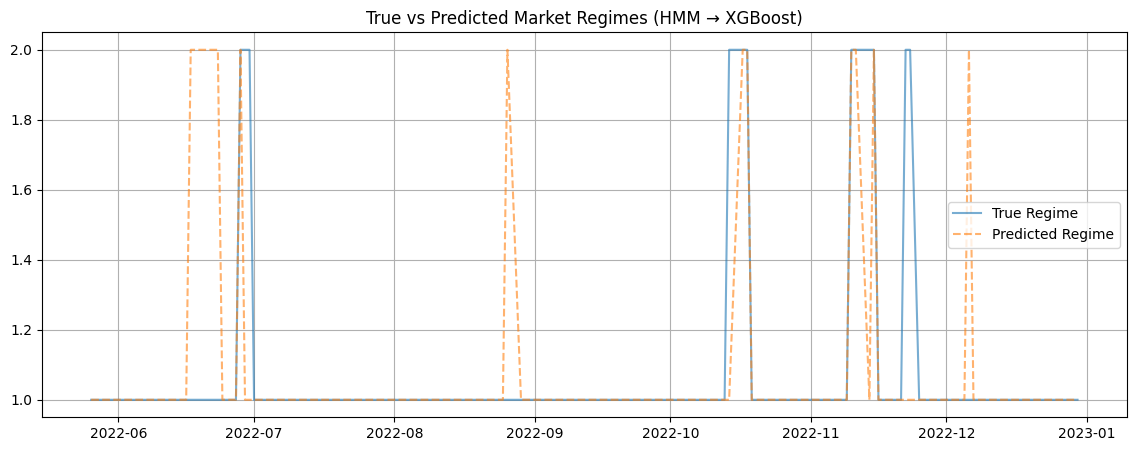

In [25]:
# Visualize true vs predicted regimes
results = pd.DataFrame({
    "date": full_features["date"].iloc[-len(y_test):],
    "true_regime": y_test.values,
    "predicted_regime": y_pred_full
}).set_index("date")

plt.figure(figsize=(14, 5))
plt.plot(results.index, results["true_regime"], label="True Regime", alpha=0.6)
plt.plot(results.index, results["predicted_regime"], label="Predicted Regime", linestyle="--", alpha=0.6)
plt.legend()
plt.title("True vs Predicted Market Regimes (HMM → XGBoost)")
plt.grid(True)
plt.show()


Source:
[1] Xiyao Fan, Classifying and Predicting Stock Market States Using HMM and XGBoost, https://medium.com/@xf600/classifying-and-predicting-stock-market-states-using-hmm-and-xgboost-c23bd4af68ed